<a href="https://colab.research.google.com/github/Neon-Purplelight/cnn_training_data_generator/blob/master/slim_base_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Script for preparing training data

In [ ]:
import os
import json
import numpy as np
import cv2

import matplotlib.pyplot as plt

from collections import defaultdict

##Defining study area
print('Defining study area')
x_min = 95000
y_min = 427000

dx, dy = 100, 100
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx #x_max = 90000 + 100*200 = 110000
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

##Defining paths and URL's
print('Defining paths and URLs')
DATA_FOLDER = '/content/drive/MyDrive/Colab Notebooks/data/data_folder/'
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
TILE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/data/tile_folder/'#'/content/data/tiles/'
if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)
GROUND_TRUTH_TILES = '/content/drive/MyDrive/Colab Notebooks/data/tile_folder/'
if not os.path.exists(GROUND_TRUTH_TILES):
    os.makedirs(GROUND_TRUTH_TILES)

json_filename = '/content/drive/MyDrive/Colab Notebooks/data/data_folder/01_01_2016_wegvakken_all_roadtypes.json'

##Declaring variables for the dictionaries
print('generating dictionaries')

dict_roadtype = {
    "G": 'Gemeinde',
    "R": 'Land',
    "P": 'Provinz',
    "W": 'Wasserbehörde',
    'T': 'Sonstige',
    '' : 'Ohne'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'null'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 0.1

INPUT_FOLDER_TILES = GROUND_TRUTH_TILES

##Defining methods for mapping
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)

    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]

def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]

##Mapping shp to tiles
print('mapping shp to tiles')
print('loading attributes')

filename = json_filename #"/content/drive/MyDrive/Colab/data/data_folder/json_file.json"
dict_wegvakken = json.load(open(filename))[FEATURES_KEY] # takes very long too. Sometimes Memory overload

print('generating dictionaries')

d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)

print('calculating roads')

for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)

            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)

print('Mapping completed')


##Plotting results for quick visual control
print('plotting results for quick visual control')

INPUT_FOLDER_TILES = GROUND_TRUTH_TILES

x0 = x_min
y0 = y_min
#POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=20,ncols=20, figsize=(16,16))

for ii in range(0,20):
    for jj in range(0,20):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = GROUND_TRUTH_TILES + tile
        tile_contents = d_tile_contents[tile]
        ax = axarr[19-jj, ii]
        image = cv2.imread(filename)

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

**Dataset preparation:**
- Provide training data in ZIP format
- Create directories for training, validation and test data and load dataset into corresponding directories
---




Loading the required libraries

In [1]:
import os
import sys
import shutil
import zipfile
import random
import gc

gc.collect()

108


Creation of variables for the required directories

In [2]:
SCRIPT_DIR = os.getcwd()
print('This script is located in: ', SCRIPT_DIR)

# dataset top level
DATASET_DIR = os.path.join(SCRIPT_DIR, 'dataset')

# train, validation and test folders
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

# class folders
TRAIN_STREET_DIR = os.path.join(TRAIN_DIR, 'street')
TRAIN_NONE_DIR = os.path.join(TRAIN_DIR, 'none')
VALID_STREET_DIR = os.path.join(VALID_DIR, 'street')
VALID_NONE_DIR = os.path.join(VALID_DIR, 'none')
TEST_STREET_DIR = os.path.join(TEST_DIR, 'street')
TEST_NONE_DIR = os.path.join(TEST_DIR, 'none')

This script is located in:  /content


Delete old directories and create directories for the current runtime

In [3]:
# remove any previous data
dir_list = [DATASET_DIR]
for dir in dir_list:
    if (os.path.exists(dir)):
        shutil.rmtree(dir)
    os.makedirs(dir)
    print("Directory" , dir ,  "created ")

# make all necessary folders
dir_list = [VALID_DIR, TEST_DIR,TRAIN_STREET_DIR,TRAIN_NONE_DIR, \
            VALID_STREET_DIR, VALID_NONE_DIR,TEST_STREET_DIR,TEST_NONE_DIR]

for dir in dir_list:
    os.makedirs(dir)
    print("Directory " , dir ,  "created ")

Directory /content/dataset created 
Directory  /content/dataset/valid created 
Directory  /content/dataset/test created 
Directory  /content/dataset/train/street created 
Directory  /content/dataset/train/none created 
Directory  /content/dataset/valid/street created 
Directory  /content/dataset/valid/none created 
Directory  /content/dataset/test/street created 
Directory  /content/dataset/test/none created 


Unpacking the ZIP archives:

**Rooth path** => /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/

---

For all resolutions for explicit examination area

---


- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_all_area/res_32_trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_all_area/res_64_trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_all_area/res_128_trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_all_area/res_256_trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_all_area/res_512_trainingdata.zip

---

Paths for specific resolution for explicit examination space

---
Amsterdam:
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/amsterdam_north-_res_32-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/amsterdam_north-_res_64-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/amsterdam_north-_res_128-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/amsterdam_north-_res_256-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/amsterdam_north-_res_512-trainingdata.zip

Groningen:
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/groningen_south-_res_32-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/groningen_south-_res_64-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/groningen_south-_res_128-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/groningen_south-_res_256-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/groningen_south-_res_512-trainingdata.zip

Leeuwarden:
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/leeuwarden-_res_32-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/leeuwarden-_res_64-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/leeuwarden-_res_128-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/leeuwarden-_res_256-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/leeuwarden-_res_512-trainingdata.zip

Rotterdam:
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/rotterdam_southeast-_res_32-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/rotterdam_southeast-_res_64-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/rotterdam_southeast-_res_128-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/rotterdam_southeast-_res_256-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/rotterdam_southeast-_res_512-trainingdata.zip

Utrecht:
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/utrecht-_res_32-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/utrecht-_res_64-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/utrecht-_res_128-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/utrecht-_res_256-trainingdata.zip
- /content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/utrecht-_res_512-trainingdata.zip

In [4]:
dataset_source = "/content/drive/MyDrive/Colab Notebooks/data/training_data/dx_100/single_res_single_area/utrecht-_res_128-trainingdata.zip"
dataset = 'utrecht-_res_128-trainingdata'

In [6]:
# unzip the trainingdata archive

zip_ref = zipfile.ZipFile(dataset_source , 'r')
zip_ref.extractall(dataset)
zip_ref.close()

print('Unzipped dataset..')

Unzipped dataset..


In [7]:
res = 256

Create list

In [8]:
# make a list of all files
imageList = list()
for (root, name, files) in os.walk(dataset):
    imageList += [os.path.join(root, file) for file in files]

Randomize list

In [9]:
random.shuffle(imageList)

Moving the files to the corresponding training, validation and test folders

In [10]:
# make lists of images according to their class
streetImages=list()
noneImages=list()

for img in imageList:
    filename = os.path.basename(img)
    class_name,_ = filename.split('_',1)
    if class_name == 'street':
        streetImages.append(img)
    else:
        noneImages.append(img)

In [11]:
# define train, valid, test split as 70:20:10 for none_street tiles
trainImages_none = int(len(noneImages) * 0.6)
validImages_none = int(len(noneImages) * 0.3)
testImages_none = int(len(noneImages) * 0.1)


In [12]:
# define train, valid, test split as 70:20:10 for street tiles
trainImages_street = int(len(streetImages) * 0.6)
validImages_street = int(len(streetImages) * 0.3)
testImages_street = int(len(streetImages) * 0.1)


In [13]:
for i in range(0,testImages_none):
    filename_n = os.path.basename(noneImages[i])
    os.rename(noneImages[i], os.path.join(TEST_NONE_DIR, filename_n))

In [14]:
for i in range(0,testImages_street):
    filename_s = os.path.basename(streetImages[i])
    os.rename(streetImages[i], os.path.join(TEST_STREET_DIR, filename_s))

In [15]:
for i in range(testImages_none,validImages_none):
    filename_n = os.path.basename(noneImages[i])
    os.rename(noneImages[i], os.path.join(VALID_NONE_DIR, filename_n))

In [16]:
for i in range(testImages_street,validImages_street):
    filename_s = os.path.basename(streetImages[i])
    os.rename(streetImages[i], os.path.join(VALID_STREET_DIR, filename_s))

In [17]:
for i in range(validImages_none,len(noneImages)):
    filename_n = os.path.basename(noneImages[i])
    os.rename(noneImages[i], os.path.join(TRAIN_NONE_DIR, filename_n))

In [18]:
for i in range(validImages_street,len(streetImages)):
    filename_s = os.path.basename(streetImages[i])
    os.rename(streetImages[i], os.path.join(TRAIN_STREET_DIR, filename_s))

In [20]:
print("Data set contains " + str(len(imageList)) + " tiles")
print("Of which are " + str(len(streetImages)) + " tiles with streets")
print("Of which are " + str(len(noneImages)) + " tiles without streets")
print("")

dir_list = [TRAIN_NONE_DIR,TRAIN_STREET_DIR,VALID_NONE_DIR,VALID_STREET_DIR,TEST_NONE_DIR,TEST_STREET_DIR]
for dir in dir_list:
    file_count = sum([len(files) for root,dir,files in os.walk(dir)])
    print('Tiles in', dir,': ',file_count)

imageList = list()
for (root, name, files) in os.walk(dataset):
    imageList += [os.path.join(root, file) for file in files]

print(str(len(dataset)) + " Tiles are left over")

Data set contains 0 tiles
Of which are 5995 tiles with streets
Of which are 4005 tiles without streets

Tiles in /content/dataset/train/none :  2804
Tiles in /content/dataset/train/street :  4197
Tiles in /content/dataset/valid/none :  801
Tiles in /content/dataset/valid/street :  1199
Tiles in /content/dataset/test/none :  400
Tiles in /content/dataset/test/street :  599
29 Tiles are left over



**Model**

Importing the required Keras modules

- import Adam - we will be usng the Adaptive Momentum optimizer.
- import binary_crossentropy - there are only two classes, so we can use binary - cross-entropy rather than softmax cross-entropy.
- import TensorBoard, EarlyStopping - these callback will be used to gather - TensorBoard data and to stop training if the validation accuracy no longers increases over a set number of epochs.
- import ImageDataGenerator - the ImageDataGenerator will produce batches of augmented data.



In [21]:

import keras
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam #old version -> funktionierte nicht mehr
from keras.losses import binary_crossentropy
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys



# Silence TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'



In [22]:
#Makes folder for the results and weights
sys.path.append('/content/drive/MyDrive/Colab Notebooks/data/results/Model_folder')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/data/results/TensorBoard_folder')




Set up the folders for storing the trained Keras model, the TensorBoard logs and the augmented images and delete any previous results.


In [23]:
#SCRIPT_DIR = os.getcwd()
#print('This script is located in: ', SCRIPT_DIR)

SCRIPT_DIR_Drive = '/content/drive/MyDrive/Colab Notebooks/results/'
print('This script is located in: ', SCRIPT_DIR_Drive)

TRAIN_DIR = os.path.join(SCRIPT_DIR, 'dataset/train')
VALID_DIR = os.path.join(SCRIPT_DIR, 'dataset/valid')
TEST_DIR = os.path.join(SCRIPT_DIR, 'dataset/test')

# Augmented images folder
AUG_IMG_DIR = os.path.join(SCRIPT_DIR,'aug_img')

# Keras model folder Colab
KERAS_MODEL_DIR = os.path.join(SCRIPT_DIR, 'keras_model')

# Keras model folder Drive
KERAS_MODEL_DIR = os.path.join(SCRIPT_DIR_Drive, 'keras_model')

# TensorBoard folder Colab
TB_LOG_DIR = os.path.join(SCRIPT_DIR, 'tb_logs')

# TensorBoard folder Drive
TB_LOG_DIR = os.path.join(SCRIPT_DIR_Drive, 'tb_logs')

# remove previous results and recreate folders -> Not if transfer learning !
dir_list = [KERAS_MODEL_DIR, TB_LOG_DIR, AUG_IMG_DIR]

for dir in dir_list:
    if (os.path.exists(dir)):
        shutil.rmtree(dir)
    os.makedirs(dir)
    print("Directory" , dir ,  "created ")

if (os.path.exists('results/results.csv')):
    os.remove('results/results.csv')


This script is located in:  /content/drive/MyDrive/Colab Notebooks/results/
Directory /content/drive/MyDrive/Colab Notebooks/results/keras_model created 
Directory /content/drive/MyDrive/Colab Notebooks/results/tb_logs created 
Directory /content/aug_img created 


Setting training parameters
Note that we are very unlikely to reach 100 epochs due to the Early Stopping callback.
(For test purposes, the epochs here are limited to 10 !)


In [24]:
EPOCHS = 10
# batchsizes for training & validation, batchsize for prediction is 1
BATCHSIZE = 32

# optimizer learning rate & decay rate
LEARN_RATE = 0.0001
DECAY_RATE = LEARN_RATE/10.0


The real-time image augmentation includes a resizing of the images. Set the image size to be 200 x 250 pixels. All images will be resized before being used in training, validation and prediction.


In [25]:
IMAGE_HEIGHT = res
IMAGE_WIDTH = res



---



The description of our CNN is contained in the customCNN.py script and uses the Keras Functional API. The CNN is fully-convolutional - the dense or fully-connected layers have been replaced with convolutional layers that have their kernel sizes, number of filters and stride lengths set such that they create output shapes that mimic the output shapes of dense/FC layers.

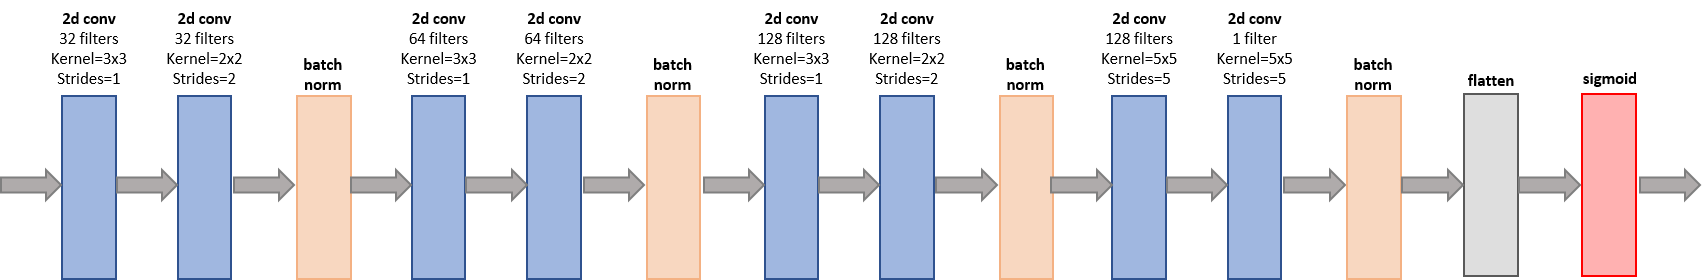

There are no pooling layers - these have also been replaced with convolutional layers that have their kernel size and strides set to the same value which is > 1. The output activation layer is a sigmoid function as we only have two classes - if the output of the sigmoid is > 0.5, the predicted class is 'street', less that 0.5 is a prediction of 'no_street'.

The CNN has deliberately been kept simple (it only has 8 convolutional layers) so the expected prediction accuracy will not be higher than approximately 90%. To reduce overfitting, batch normalization layers have been used and also L2 kernel regularization.


In [26]:
'''
Simple custom CNN
There are no pooling layers, instead convolution layers with
2x2 kernels and stride length = 2 are used for data reduction.
Dense layers are also replaced with convolution layers.
Sigmoid activation in the final layer.
'''

from keras.models import Model
from keras import regularizers
from keras.layers import Input, Flatten, Conv2D
from keras.layers import BatchNormalization, Activation


# wrapper function for the 2D convolution layer
def conv_layer(input, filters, kernel_size, strides=1):

      return Conv2D(filters=filters, kernel_size=kernel_size, kernel_initializer='he_uniform', \
                    kernel_regularizer=regularizers.l2(0.01), \
                    strides=strides, activation='relu', padding='same')(input)


#for Greyscale:
def customCNN(input_shape=(512, 512, 1)):

      input_layer = Input(shape=input_shape)

      net = conv_layer(input_layer, 32, 3)
      net = conv_layer(net, 32, 2, 2)
      net = BatchNormalization()(net)

      net = conv_layer(net, 64, 3)
      net = conv_layer(net, 64, 2, 2)
      net = BatchNormalization()(net)

      net = conv_layer(net, 128, 3)
      net = conv_layer(net, 128, 2, 2)
      net = BatchNormalization()(net)

      net = conv_layer(net, 128, 5, 5)
      #Hier extra convolution für 512 Datensätze !
      net = conv_layer(net, 128, 5, 5)
      net = conv_layer(net, 1, 5, 7)
      net = BatchNormalization()(net)
      net = Flatten()(net)
      output_layer = Activation('sigmoid')(net)

      return Model(inputs=input_layer, outputs=output_layer)

In [ ]:
'''
VGG16
Angepasst
'''

'''import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


#for Greyscale:
def customCNN(input_shape=(512, 512, 1)):

  model = Sequential()
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=2, activation="softmax"))

from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model = customCNN(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))'''



In [27]:
#for greyscale
model = customCNN(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
#for RGB
#model = customCNN(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

#For transfer learning => Cat Dog
#model.load_weights ('/content/drive/MyDrive/Colab/keras_model/k_model_weights.h5')#('/content/drive/MyDrive/Colab_Notebooks/cat_dog_example/keras_model/k_model_weights.h5')

# print a summary of the model
print(model.summary())
print("Model Inputs: {ips}".format(ips=(model.inputs)))
print("Model Outputs: {ops}".format(ops=(model.outputs)))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        16448     
                                                             



Next we declare two instances of the ImageDataGenerator class. The first, datagen_tv, will perform image augmentation for training and validation. The second, datagen_p for prediction.

The image augmentation for training and validation is performed on-the-fly and is composed of:

- the 8bit pixel data is normalized from 0:225 to the range 0:1.0
- a random rotation of 5° max
- random horizontal flipping i.e flipping about the vertical axis to produce a mirror image.
- random horizontal and vertical shifts of the image by 10% of the image size (200 x 200 in this case).

We only use pixel normalization for the prediction augmentation.


In [28]:
datagen_tv = ImageDataGenerator(rescale=1/255,
                                rotation_range=5,
                                horizontal_flip=True,
                                height_shift_range=0.1,
                                width_shift_range=0.1
                                )

# data generation for prediction - only rescaling
datagen_p = ImageDataGenerator(rescale=1/255)

In [29]:
# train generator takes images from the specified directory, applies
# a resize to IMAGE_HEIGHT x IMAGE_WIDTH with bilinear interpolation.
train_generator = datagen_tv.flow_from_directory(TRAIN_DIR,
                                                 target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                 interpolation='bilinear',
                                                 color_mode="grayscale",
                                                 batch_size=BATCHSIZE,
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 seed=42
                                                 )
'''
uncomment save_to_dir=AUG_IMG_DIR to save the augmented images
note that this will take up considerable disk space
'''
validation_generator = datagen_tv.flow_from_directory(VALID_DIR,
                                                      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                      interpolation='bilinear',
                                                      color_mode="grayscale",
                                                      batch_size=BATCHSIZE,
                                                      class_mode='binary',
                                                      shuffle=True,
                                                    # save_to_dir=AUG_IMG_DIR
                                                      )


prediction_generator = datagen_p.flow_from_directory(TEST_DIR,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     interpolation='bilinear',
                                                     color_mode="grayscale",
                                                     batch_size=1,
                                                     class_mode='binary',
                                                     shuffle=False)



##############################################
# Compile model
##############################################
# Adam optimizer to change weights & biases
# Loss function is binary crossentropy

from tensorflow.keras.optimizers.legacy import Adam

# Modell kompilieren
model.compile(optimizer=Adam(learning_rate=LEARN_RATE, decay=0.0),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

Found 7001 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 999 images belonging to 2 classes.




Setting up two Callbacks. The first is for collecting TensorBoard data. The second defines a means for halting the training if the validation accuracy stops improving for 5 epochs. Once training stops, the model parameters from the epoch that gave the best results in terms of validation accuracy are restored.


In [30]:
# create Tensorboard callback Colab
tb_call = TensorBoard(log_dir=TB_LOG_DIR,
                      batch_size=BATCHSIZE)

earlystop_call = EarlyStopping(monitor='val_binary_accuracy',
                               mode='max',
                               min_delta=0.0001,
                               patience=5,
                               restore_best_weights=True)


callbacks_list = [tb_call, earlystop_call]



Run the training.


In [31]:
# calculate number of steps in one training epoch
train_steps = train_generator.n//train_generator.batch_size

# calculate number of steps in one validation epoch
val_steps = validation_generator.n//validation_generator.batch_size

# run training
training_history=model.fit_generator(generator=train_generator,
                                  epochs=EPOCHS,
                                  steps_per_epoch=train_steps,
                                  validation_data=validation_generator,
                                  validation_steps=val_steps,
                                  callbacks=callbacks_list,
                                  shuffle=True)


#print("\nTo open TensorBoard: tensorboard --logdir={dir} --host localhost --port 6006".format(dir=TB_LOG_DIR))

<ipython-input-31-ebdb42fcba1b>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history=model.fit_generator(generator=train_generator,


Epoch 1/10
218/218 [==============================] - 1437s 7s/step - loss: 12.9012 - binary_accuracy: 0.8040 - val_loss: 11.5154 - val_binary_accuracy: 0.4002
Epoch 2/10
218/218 [==============================] - 1406s 6s/step - loss: 9.2906 - binary_accuracy: 0.8310 - val_loss: 8.1133 - val_binary_accuracy: 0.4133
Epoch 3/10
218/218 [==============================] - 1408s 6s/step - loss: 6.6097 - binary_accuracy: 0.8360 - val_loss: 5.7394 - val_binary_accuracy: 0.6487
Epoch 4/10
218/218 [==============================] - 1402s 6s/step - loss: 4.7832 - binary_accuracy: 0.8437 - val_loss: 4.2374 - val_binary_accuracy: 0.6946
Epoch 5/10
218/218 [==============================] - 1374s 6s/step - loss: 3.5633 - binary_accuracy: 0.8455 - val_loss: 3.1794 - val_binary_accuracy: 0.7828
Epoch 6/10
218/218 [==============================] - 1422s 7s/step - loss: 2.7441 - binary_accuracy: 0.8506 - val_loss: 2.5719 - val_binary_accuracy: 0.7112
Epoch 7/10
218/218 [==============================



After training has finished, we can run a final evaluation using the validation set. The data used comes from the validation generator and we run the complete validation set for 1 epoch. evaluate_generator returns the evaluation loss and accuracy.


In [34]:
scores = model.evaluate_generator(generator=validation_generator,
                                  max_queue_size=10,
                                  steps=val_steps,
                                  verbose=1)

print ('Evaluation Loss    : ', scores[0])
print ('Evaluation Accuracy: ', scores[1])

<ipython-input-34-c3f5e4ac4631>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(generator=validation_generator,


62/62 [==============================] - 124s 2s/step - loss: 1.3701 - binary_accuracy: 0.8216
Evaluation Loss    :  1.370100498199463
Evaluation Accuracy:  0.8215726017951965




As an extra, optional step we can make predictions using the trained model. The predict_generator returns a list of predictions that it makes from the data fed to the prediction_generator - the test dataset in this case.


In [36]:
# reset the generator before using it for predictions
prediction_generator.reset()

# calculate number of steps for prediction
predict_steps = prediction_generator.n

# predict generator returns a list of all predictions
pred = model.predict_generator(generator=prediction_generator,
                               steps=predict_steps,
                               verbose=1)

<ipython-input-36-5905f42492ff>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(generator=prediction_generator,


999/999 [==============================] - 53s 53ms/step




We don't have a list of labels that match the data sent to the prediction generator, so we need to extract the 'ground truth' labels from the filenames in the test dataset. We do this by first creating a list of the filenames that were used during prediction - it is important to understand that this list will be in the order in which the image files were applied to the prediction generator.


In [37]:
# get a list of image filenames used in prediction
filenames = prediction_generator.filenames



Another attribute of the prediction generator, .class_indices, will give us a dictionary where the classes are the keys. {'streets': 0, 'no_streets': 1}

We then swap the keys and values so that we can use the predictions to index the dictionary and get back the associated class.


In [38]:
# the .class_indices attribute returns a dictionary with keys = classes
labels = (prediction_generator.class_indices)
print(labels)

# make a new dictionary with keys & values swapped
labels = dict((v,k) for k,v in labels.items())
print(labels)

{'none': 0, 'street': 1}
{0: 'none', 1: 'street'}




Now we can run through the list of predictions and decide f they are 'cat or 'dog'. The values in the list of predictions come from the sigmoid activation function, so they are floating-point values between 0 and 1. Any value < 0.5 is class 0 and any value above 0.5 is class 1.


In [39]:
# use the 'labels dictionary to create a list of predictions as strings
# predictions is a list of sigmoid outputs
# if sigmoid output < 0.5, CNN predicted class 0
# if sigmoid output > 0.5, CNN predicted class 1
predictions = list()
for i in range(len(pred)):
    if pred[i] > 0.5:
        predictions.append(labels[1])
    else:
        predictions.append(labels[0])



Now that we have a list of predictions that are strings (i.e. either 'street' or 'mo_streets') we can compare this list to the ground truth labels (extracted from the filenames) to calculate accuracy.


In [40]:
# iterate over the list of predictions and compare to ground truth labels
# ground truth labels are derived from prediction filenames.
correct_predictions = 0
wrong_predictions = 0

for i in range (len(predictions)):

    # ground truth is first part of filename (i.e. the class folder)
    # will need to be modified to '\' for windows
    ground_truth, _ = filenames[i].split('/',1)

    # compare prediction to ground truth
    if predictions[i] == ground_truth:
        correct_predictions += 1
    else:
        wrong_predictions += 1

# calculate accuracy
acc = (correct_predictions/len(predictions)) * 100

print('Correct Predictions: ',correct_predictions)
print('Wrong Predictions  : ',wrong_predictions)
print('Prediction Accuracy: ',acc,'%')

Correct Predictions:  812
Wrong Predictions  :  187
Prediction Accuracy:  81.28128128128128 %




Make a .csv file for the prediction results:


In [41]:
# write filenames and associated predictions to .csv file
results = pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions})
results.to_csv('results.csv',index=False)

#Drive results
results.to_csv('/content/drive/MyDrive/Colab Notebooks/results.csv',index=False)

print('\nPredictions and true labels saved to results.csv')


Predictions and true labels saved to results.csv


In [ ]:
'''# save just the weights (no architecture) to an HDF5 format file
model.save_weights(os.path.join(KERAS_MODEL_DIR,'k_model_weights.h5'))

# save just the architecture (no weights) to a JSON file
with open(os.path.join(KERAS_MODEL_DIR,'k_model_architecture.json'), 'w') as f:
    f.write(model.to_json())

print('\nTrained model saved to {dir}'.format(dir=KERAS_MODEL_DIR))'''

In [42]:
print(dataset)
print("")
print("Datensatz entält " + str(len(imageList)) + " Kacheln")
print("Davon sind " + str(len(streetImages)) + " Kacheln mit Straßen")
print("Davon sind " + str(len(noneImages)) + " Kacheln ohne Straßen")
print("")

dir_list = [TRAIN_NONE_DIR,TRAIN_STREET_DIR,VALID_NONE_DIR,VALID_STREET_DIR,TEST_NONE_DIR,TEST_STREET_DIR]
for dir in dir_list:
    file_count = sum([len(files) for root,dir,files in os.walk(dir)])
    print('Kacheln in', dir,': ',file_count)

imageList = list()
for (root, name, files) in os.walk(dataset):
    imageList += [os.path.join(root, file) for file in files]

print(str(len(dataset)) + " Kacheln sind übrig geblieben")
print("")
print("Batchsize: " + str(BATCHSIZE))
print("Learnrate: " + str(LEARN_RATE))
print("Learnrate decay: " + str(DECAY_RATE))
print("")
print(model.summary())
print("Model Inputs: {ips}".format(ips=(model.inputs)))
print("Model Outputs: {ops}".format(ops=(model.outputs)))
print("")
print ('Evaluation Loss    : ', scores[0])
print ('Evaluation Accuracy: ', scores[1])
print("")
print('Correct Predictions: ',correct_predictions)
print('Wrong Predictions  : ',wrong_predictions)
print('Prediction Accuracy: ',acc,'%')
print("")


utrecht-_res_128-trainingdata

Datensatz entält 0 Kacheln
Davon sind 5995 Kacheln mit Straßen
Davon sind 4005 Kacheln ohne Straßen

Kacheln in /content/dataset/train/none :  2804
Kacheln in /content/dataset/train/street :  4197
Kacheln in /content/dataset/valid/none :  801
Kacheln in /content/dataset/valid/street :  1199
Kacheln in /content/dataset/test/none :  400
Kacheln in /content/dataset/test/street :  599
29 Kacheln sind übrig geblieben

Batchsize: 32
Learnrate: 0.0001
Learnrate decay: 1e-05

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                   

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


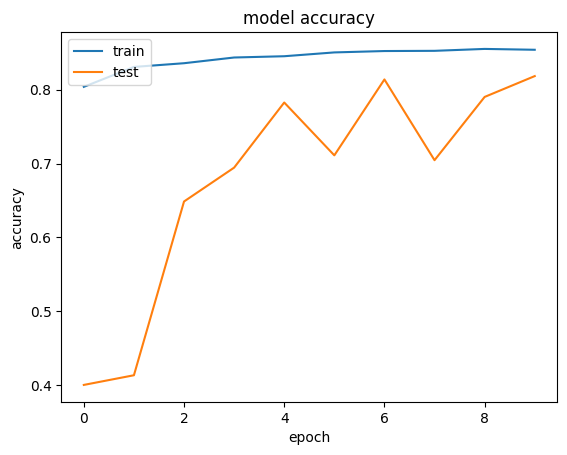

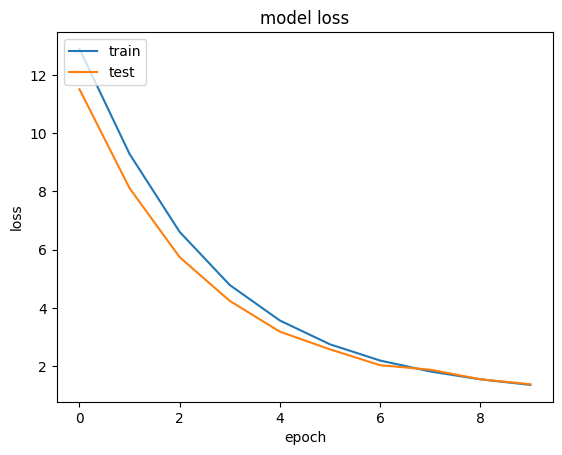

In [43]:
##Gibt plot aus
# list all data in history
print(training_history.history.keys())
# summarize history for accuracy
plt.plot(training_history.history['binary_accuracy'])
plt.plot(training_history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

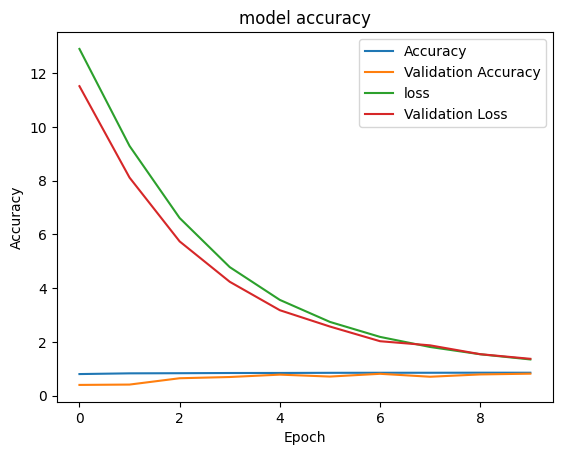

In [45]:
## Alle Ergebnisse in einem Plot
import matplotlib.pyplot as plt
plt.plot(training_history.history["binary_accuracy"])
plt.plot(training_history.history['val_binary_accuracy'])
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [46]:
def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['binary_accuracy'])
    acc = history.history['binary_accuracy'][:steps]
    val_acc = history.history['val_binary_accuracy'][:steps]
    loss = history.history['loss'][:steps]
    val_loss = history.history['val_loss'][:steps]

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

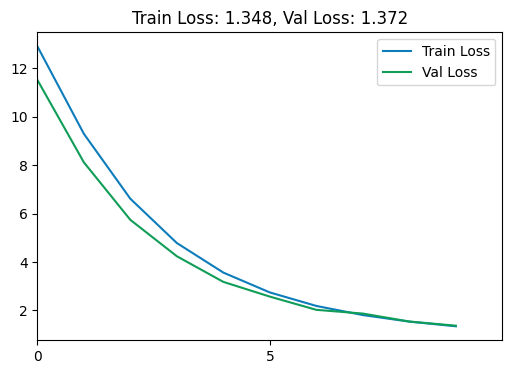

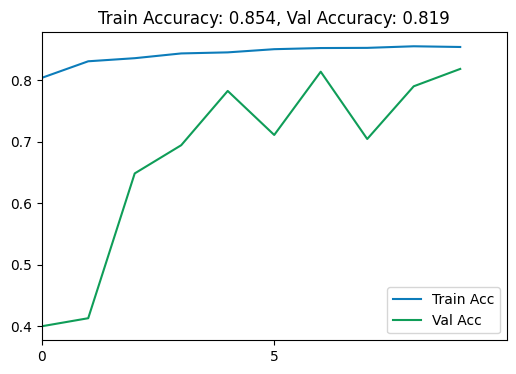

In [47]:
plot_compare(training_history)



The trained model is saved in the directory pointed to by the variable KERAS_MODEL_DIR. The model weights and biases are stored in an HDF5 format file called 'k_model_weights.h5'. The architecture (without weights) is stored in a JSON file called 'k_model_architecture.json'.


In [ ]:
'''#!kill 695
%reload_ext tensorboard

%tensorboard --logdir  '/content/drive/MyDrive/Colab Notebooks/results/tb_logs/train'

#%tensorboard --logdir /content/drive/MyDrive/Colab_Notebooks/cat_dog_example/tb_logs/validation'''